<a href="https://colab.research.google.com/github/rahiakela/modern-computer-vision-with-pytorch/blob/main/8-advanced-object-detection/1_training_faster_r_cnn_based_custom_object_detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Faster R-CNN-based custom object detectors

One of the major drawbacks of R-CNN is that it takes considerable time to generate predictions, as generating region proposals for each image, resizing the crops of regions, and extracting features corresponding to each crop (region proposal), constitute the bottleneck.

Fast R-CNN gets around this problem by passing the entire image through the
pretrained model to extract features and then fetching the region of features that correspond to the region proposals (which are obtained from selectivesearch) of the original image.

In this notebook, we will learn about the working details of R-CNN before training it on our custom dataset.

## Setup

In [ ]:
!pip install -q --upgrade selectivesearch torch_snippets

In [ ]:
from torch_snippets import *
import selectivesearch

In [ ]:
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
from torchvision.ops import RoIPool

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

## Working details of Fast R-CNN

Let's understand Fast R-CNN through the following diagram:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/fast-r-cnn.png?raw=1' width='800'/>

We perform the following steps when leveraging the Fast R-CNN technique for object detection:

1. Pass the image through a pretrained model to extract features prior to the
flattening layer; let's call the output as feature maps.
2. Extract region proposals corresponding to the image.
3. Extract the feature map area corresponding to the region proposals (note
that when an image is passed through a VGG16 architecture, the image is
downscaled by 32 at the output as there are 5 pooling operations
performed. Thus, if a region exists with a bounding box of (40,32,200,240)
in the original image, the feature map corresponding to the bounding box
of (5,4,25,30) would correspond to the exact same region).
4. Pass the feature maps corresponding to region proposals through the RoI
(Region of Interest) pooling layer one at a time so that all feature maps of
region proposals have a similar shape. This is a replacement for the
warping that was executed in the R-CNN technique.
5. Pass the RoI pooling layer output value through a fully connected layer.
6. Train the model to predict the class and offsets corresponding to each
region proposal.

>>Note that the big difference between R-CNN and Fast R-CNN is
that, in R-CNN, we are passing the crops (resized region proposals)
through the pretrained model one at a time, while in Fast R-CNN,
we are cropping the feature map (which is obtained by passing the
whole image through a pretrained model) corresponding to each
region proposal and thereby avoiding the need to pass each resized
region proposal through the pretrained model.

## Implementing Fast R-CNN for object detection on a custom dataset

In this section, we will work toward training our custom object detector using Fast RCNN. Furthermore, so as to remain succinct, we provide only the additional or the changed code in this section.

## Downloading the dataset

For the scenario of object detection, we will download the data from Kaggle that is the Google Open Images v6 dataset.

However, we will work on only those images that are of a bus or a truck to ensure that we can train images (as you will shortly notice the memory issues associated with using selectivesearch).



In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahiakela","key":"484f91b2ebc194b0bff8ab8777c1ebff"}'}

In [ ]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download dataset from kaggle
kaggle datasets download -d sixhky/open-images-bus-trucks/
unzip -qq open-images-bus-trucks.zip

kaggle.json
open-images-bus-trucks.zip: Skipping, found more recently modified local copy (use --force to force download)
replace df.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Preparing the dataset

Now that we have downloaded the dataset, we will prepare the dataset. This involves the following steps:

1. Fetching each image and its corresponding class and bounding box values
2. Fetching the region proposals within each image, their corresponding IoU, and the delta by which the region proposal is to be corrected with respect to the ground truth
3. Assigning numeric labels for each class (where we have an additional background class (besides the bus and truck classes) where IoU with the ground truth bounding box is below a threshold)
4. Resizing each region proposal to a common size in order to pass them to a network

By the end of this exercise, we will have resized crops of region proposals, along with assigning the ground truth class to each region proposal, and calculated the offset of the region proposal in relation to the ground truth bounding box. 

Specify the location of images and read the ground truths present in the CSV file that we downloaded:

In [ ]:
IMAGE_ROOT = "images/images/"
DF_RAW = pd.read_csv("df.csv")
print(DF_RAW.head())

            ImageID  Source LabelName  ...  XClick2Y  XClick3Y  XClick4Y
0  0000599864fd15b3  xclick       Bus  ...  0.512700  0.650047  0.457197
1  00006bdb1eb5cd74  xclick     Truck  ...  0.241855  0.352130  0.437343
2  00006bdb1eb5cd74  xclick     Truck  ...  0.398496  0.409774  0.295739
3  00010bf498b64bab  xclick       Bus  ...  0.493882  0.705228  0.521691
4  00013f14dd4e168f  xclick       Bus  ...  0.303940  0.999062  0.523452

[5 rows x 21 columns]


Note that `XMin`, `XMax`, `YMin`, and `YMax` correspond to the ground truth of the bounding box of the image. Furthermore, LabelName provides the class of image.

Define a class that returns the image and its corresponding class and ground truth along with the file path of the image:

In [ ]:
class OpenImages(Dataset):

  def __init__(self, df, image_folder=IMAGE_ROOT):
    self.root = image_folder
    self.df = df
    self.unique_images = df["ImageID"].unique()

  def __len__(self):
    return len(self.unique_images)

  def __getitem__(self, idx):
    image_id = self.unique_images[idx]
    image_path = f"{self.root}/{image_id}.jpg"
    image = cv2.imread(image_path, 1)[..., ::-1]   # conver BGR to RGB
    h, w, _ = image.shape
    df = self.df.copy()
    df = df[df["ImageID"] == image_id]
    boxes = df["XMin,YMin,XMax,YMax".split(",")].values
    boxes = (boxes * np.array([w, h, w, h])).astype(np.uint16).tolist()
    classes = df["LabelName"].values.tolist()

    return image,boxes, classes, image_path

Inspect a sample image and its corresponding class and bounding box ground truth:

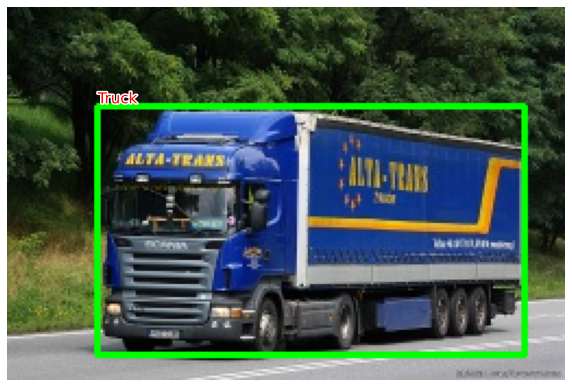

In [ ]:
ds = OpenImages(df=DF_RAW)
img, bbs, clazz, _ = ds[9]
show(img, bbs=bbs, texts=clazz, sz=10)

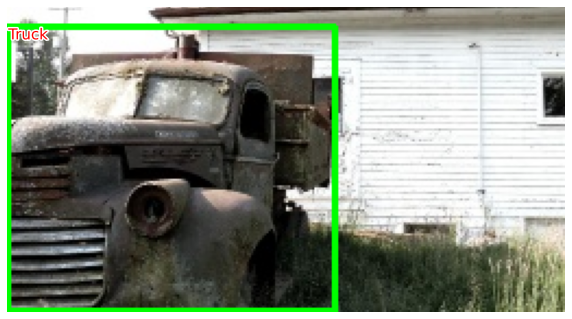

In [ ]:
ds = OpenImages(df=DF_RAW)
img, bbs, clazz, _ = ds[8]
show(img, bbs=bbs, texts=clazz, sz=10)

Define the extract_iou and extract_candidates functions:

In [ ]:
def extract_candidates(img):
  img_label, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
  img_area = np.prod(img.shape[:2])
  candidates = []

  for r in regions:
    if r["rect"] in candidates:
      continue
    if r["size"] < (0.05 * img_area):
      continue
    if r["size"] > (1 * img_area):
      continue
    x, y, w, h = r["rect"]
    candidates.append(list(r["rect"]))
  return candidates

In [ ]:
def extract_iou(boxA, boxB, epsilon=1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])

  width = (x2 - x1)
  height = (y2 - y1)

  if (width < 0) or (height < 0):
    return 0.0
  
  area_overlap = width * height
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b - area_overlap

  iou = area_overlap / (area_combined + epsilon)

  return iou

By now, we have defined all the functions necessary to prepare data and initialize data loaders.

## Defining the region proposals extraction and IoU calculation functions

we will learn about creating the input and output values corresponding to our model. The input constitutes the candidates that are extracted using the selectivesearch method and the output constitutes the class corresponding to candidates and the offset of the candidate with respect to the bounding box it overlaps the most with if the candidate contains an object.

**1.** Initialize empty lists to store file paths, ground truth bounding boxes , classes of objects, the delta offset of a bounding box with region proposals, region proposal locations, and the IoU of region proposals with ground truths:

In [ ]:
FILE_PATHS, GTBBS, CLAZZ, DELTAS, ROIS, IOUS = [], [], [], [], [], []

**2.**Loop through the dataset and populate the lists initialized above:

In [ ]:
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
  if(ix==N):
      break
  H, W, _ = im.shape
  candidates = extract_candidates(im)
  candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
  ious, rois, clss, deltas = [], [], [], []
  ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
  for jx, candidate in enumerate(candidates):
      cx,cy,cX,cY = candidate
      candidate_ious = ious[jx]
      best_iou_at = np.argmax(candidate_ious)
      best_iou = candidate_ious[best_iou_at]
      best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
      if best_iou > 0.3: clss.append(labels[best_iou_at])
      else : clss.append('background')
      delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
      deltas.append(delta)
      rois.append(candidate / np.array([W,H,W,H]))
  FILE_PATHS.append(fpath)
  IOUS.append(ious)
  ROIS.append(rois)
  CLAZZ.append(clss)
  DELTAS.append(deltas)
  GTBBS.append(bbs)

Fetch the image path names and store all the information obtained, FPATHS, IOUS, ROIS, CLSS, DELTAS, and GTBBS, in a list of lists:

In [ ]:
FILE_PATHS = [f"{IMAGE_ROOT}/{stem(f)}.jpg" for f in FILE_PATHS]
FILE_PATHS, GTBBS, CLAZZ, DELTAS, ROIS = [item for item in [FILE_PATHS, GTBBS, CLAZZ, DELTAS, ROIS]]

Note that, so far, classes are available as the name of the class. Now, we will convert them into their corresponding indices so that a background class has a class index of 0, a bus class has a class index of 1, and a truck class has a class index of 2.

**3.** Assign indices to each class:

In [ ]:
targets = pd.DataFrame(flatten(CLAZZ), columns=["label"])
label2target = {label: target for target, label in enumerate(targets["label"].unique())}
target2label = {target: label for label, target in label2target.items()}
background_class = label2target["background"]

So far, we have assigned a class to each region proposal and also created the other ground truth of the bounding box offset.

## Creating the training data

We will prepare a dataset class based on the ground truth of region
proposals that are obtained by the end of step 8 and create data loaders from it. 

Next, we will normalize each region proposal by resizing them to the same shape and scaling them.

In [ ]:
# Define the function to normalize an image
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
# Define a function to preprocess the image
def preprocess_image(img):
  img = torch.tensor(img).permute(2, 0, 1)
  img = normalize(img)
  
  return img.to(device).float()

def decode(_y):
  _, preds = _y.max(-1)

  return preds

In [ ]:
# Define the dataset using the preprocessed region proposals along with the ground truths
class FRCNNDataset(Dataset):

    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]

        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'

        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        print(input)
        input = torch.cat(input).to(device)
        print(rois)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)

        return input, rois, rixs, labels, deltas

In [ ]:
# Create the training and validation datasets and data loaders
n_train = 9 * len(FILE_PATHS) // 10
train_ds = FRCNNDataset(FILE_PATHS[:n_train], ROIS[:n_train], CLAZZ[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FILE_PATHS[n_train:], ROIS[n_train:], CLAZZ[n_train:], DELTAS[n_train:], GTBBS[n_train:])

In [ ]:
len(train_ds)

450

In [ ]:
len(test_ds)

50

In [ ]:
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [ ]:
len(train_loader)

225

## R-CNN network architecture

Now that we have prepared the data, we will learn about building a
model that can predict both the class of region proposal and the offset corresponding to it in order to draw a tight bounding box around the object in the image.

In [ ]:
# Define the FRCNN network module
class FRCNN(nn.Module):

  def __init__(self):
    super().__init__()
    # Load the pretrained model and freeze the parameters
    rawnet = torchvision.models.vgg16_bn(pretrained=True)
    for param in rawnet.features.parameters():
      param.requires_grad = True
    # Extract features until the last layer
    self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
    # Specify that RoIPool is to extract a 7 x 7 output
    self.roipool = RoIPool(7, spatial_scale=14 / 224)

    # Define the output heads – cls_score and bbox
    feature_dim = 512 * 7 * 7
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(
        nn.Linear(feature_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 4),
        nn.Tanh()
    )

    # Define the loss functions
    self.cross_entropy_loss = nn.CrossEntropyLoss()
    self.l1_loss = nn.L1Loss()

  def forward(self, inputs, rois, ridx):
    res = inputs
    res = self.seq(res)
    rois = torch.cat([ridx.unsqueeze(-1), rois * 224], dim=-1)
    res = self.roipool(res, rois)
    feature = res.view(len(res), -1)
    cls_score = self.cls_score(feature)
    bbox = self.bbox(feature)   # .view(-1, len(label2target), 4)

    return cls_score, bbox

  def calculate_loss(self, probs, _deltas, labels, deltas):
    detection_loss = self.cross_entropy_loss(probs, labels)
    ixs, = torch.where(labels != background_class)
    _deltas = _deltas[ixs]
    deltas = deltas[ixs]
    self.lmb = 10.0
    if len(ixs) > 0:
      regression_loss = self.l1_loss(_deltas, deltas)
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
    else:
      regression_loss = 0
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

Define the functions to train and validate on a batch.

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
  inputs, rois, rixs, clazz, deltas = inputs
  model.train()
  optimizer.zero_grad()
  _clazz, _deltas = model(inputs, rois, rixs)
  loss, loc_loss, regr_loss = criterion(_clazz, _deltas, clazz, deltas)
  accs = clazz == decode(_clazz)
  loss.backward()
  optimizer.step()

  return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
  inputs, rois, rixs, clazz, deltas = inputs
  with torch.no_grad():
    model.eval()
    _clazz, _deltas = model(inputs, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clazz, _deltas, clazz, deltas)
    _clazz = decode(_clazz)
    accs = clazz == _clazz
  return _clazz, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

Now, let's create an object of the model, fetch the loss criterion, and then
define the optimizer and the number of epochs:

In [ ]:
frcnn = FRCNN().to(device)
criterion = frcnn.calculate_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

We now train the model over increasing epochs.

Streaming output truncated to the last 5000 lines.
          [ 2.0125,  0.8448,  0.8448,  ...,  0.2522,  0.1825,  1.1934],
          ...,
          [ 1.8731,  0.7925,  0.6008,  ...,  0.5485,  0.5834,  1.4025],
          [ 1.8557,  1.0714,  0.8099,  ...,  0.7054,  0.7925,  1.4374],
          [ 1.8383,  1.7685,  1.5420,  ...,  1.4548,  1.5071,  1.7511]]]],
       device='cuda:0')]
[array([0.41796875, 0.        , 0.99609375, 0.49122807]), array([0.        , 0.44444444, 0.1875    , 0.88304094]), array([0.        , 0.66666667, 0.66015625, 0.99415205]), array([0.        , 0.44444444, 0.24609375, 0.88304094]), array([0.55859375, 0.25730994, 0.99609375, 0.78362573]), array([0.        , 0.34502924, 0.26171875, 0.88304094]), array([0.140625  , 0.18128655, 0.63671875, 0.67836257]), array([0.41796875, 0.        , 0.99609375, 0.49122807]), array([0.55859375, 0.25730994, 0.99609375, 0.81871345]), array([0.        , 0.66666667, 0.66015625, 0.99415205]), array([0.        , 0.61988304, 0.7578125 , 0.99

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:00<00:00, 627.37it/s]

[tensor([[[[ 1.9407,  1.9407,  1.9407,  ...,  1.1872,  1.1700,  1.1700],
          [ 1.9407,  1.9407,  1.9407,  ...,  1.1872,  1.1700,  1.1700],
          [ 1.9578,  1.9578,  1.9407,  ...,  1.1700,  1.1700,  1.1700],
          ...,
          [ 0.2453,  0.2796,  0.2111,  ..., -0.2342, -0.3369, -0.4054],
          [ 0.2453,  0.2282,  0.2453,  ..., -0.3883, -0.3369, -0.5253],
          [ 0.2624,  0.1768,  0.2453,  ..., -0.5253, -0.3369, -0.6452]],

         [[ 2.1660,  2.1660,  2.1660,  ...,  1.5707,  1.5532,  1.5532],
          [ 2.1660,  2.1660,  2.1660,  ...,  1.5707,  1.5532,  1.5532],
          [ 2.1835,  2.1835,  2.1660,  ...,  1.5532,  1.5532,  1.5532],
          ...,
          [ 0.2227,  0.2577,  0.1877,  ..., -0.2325, -0.3375, -0.4076],
          [ 0.2227,  0.2052,  0.2052,  ..., -0.3901, -0.3375, -0.5301],
          [ 0.2402,  0.1527,  0.2227,  ..., -0.5301, -0.3375, -0.6527]],

         [[ 2.4657,  2.4657,  2.4483,  ...,  2.0823,  2.0648,  2.0648],
          [ 2.4657,  2.4657, 

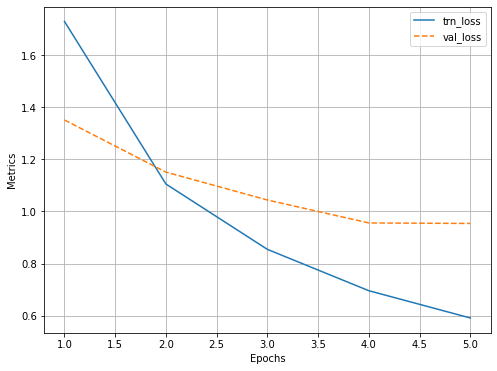

In [ ]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    #print(inputs.size())
    loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, optimizer, criterion)
    pos = (epoch + (ix + 1) / _n)
    log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, trn_regr_loss=regr_loss, trn_acc=accs.mean(), end="\r")
  
  _n = len(test_loader)
  for ix, inputs in enumerate(test_loader):
    _clazz, _deltas, loss, loc_loss, regr_loss, accs = validate_batch(inputs, frcnn, criterion)
    pos = (epoch + (ix + 1) / _n)
    log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, val_regr_loss=regr_loss, val_acc=accs.mean(), end="\r")

  log.report_avgs(epoch + 1)
  
# Plotting training and validation metrics
log.plot_epochs("trn_loss,val_loss".split(","))

### Predict on a new image

we will leverage the model trained so far to predict and draw
bounding boxes around objects and the corresponding class of object within the
predicted bounding box on new images. The strategy we adopt is as follows:

1. Extract region proposals from the new image.
2. Resize and normalize each crop.
3. Feed-forward the processed crops to make predictions of class and the
offsets.
4. Perform non-max suppression to fetch only those boxes that have the
highest confidence of containing an object.

We execute the preceding strategy through a function that takes an image as input and a ground truth bounding box (this is used only so that we compare the ground truth and the predicted bounding box).



In [ ]:
def test_predictions(filename, show_output=True):
  # Read the image and resizes it to 224 x 224
  img = cv2.resize(np.array(Image.open(filename)), (224, 224))
  # Obtain region proposals and convert them to (x1,y1,x2,y2) format
  candidates = extract_candidates(img)
  # then convert these values to the ratio of width and height
  candidates = [(x, y, x + w, y + h) for x, y, w, h in candidates]
  # Preprocess the image and scale the region of interests
  inputs = preprocess_image(img / 255.)[None]
  rois = [[x / 224, y / 224, X / 224, Y / 224] for x, y, X, Y in candidates]
  # As all proposals belong to the same image, rixs will be a list of zeros
  rixs = np.array([0] * len(rois))

  # Forward propagate the input and rois through the trained model and get confidences and class scores for each proposal
  rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
  with torch.no_grad():
    frcnn.eval()
    probs, deltas = frcnn(inputs, rois, rixs)
    confs, clss = torch.max(probs, -1)

  # Filter out the background class
  candidates = np.array(candidates)
  confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
  ixs = clss!=background_class
  confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
  bbs = candidates + deltas

  # Remove near-duplicate bounding boxes with nms and get indices of those proposals in which the models that are highly confident are objects:
  ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
  confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
  if len(ixs) == 1:
    confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
  bbs = bbs.astype(np.uint16)

  # Plot the image along with the predicted bounding box
  _, ax = plt.subplots(1, 2, figsize=(20, 10))
  show(img, ax=ax[0])
  ax[0].grid(False)
  ax[0].set_title(filename.split("/")[-1])
  if len(confs) == 0:
      ax[1].imshow(img)
      ax[1].set_title('No objects')
      plt.show()
      return
  else:
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
    plt.show()

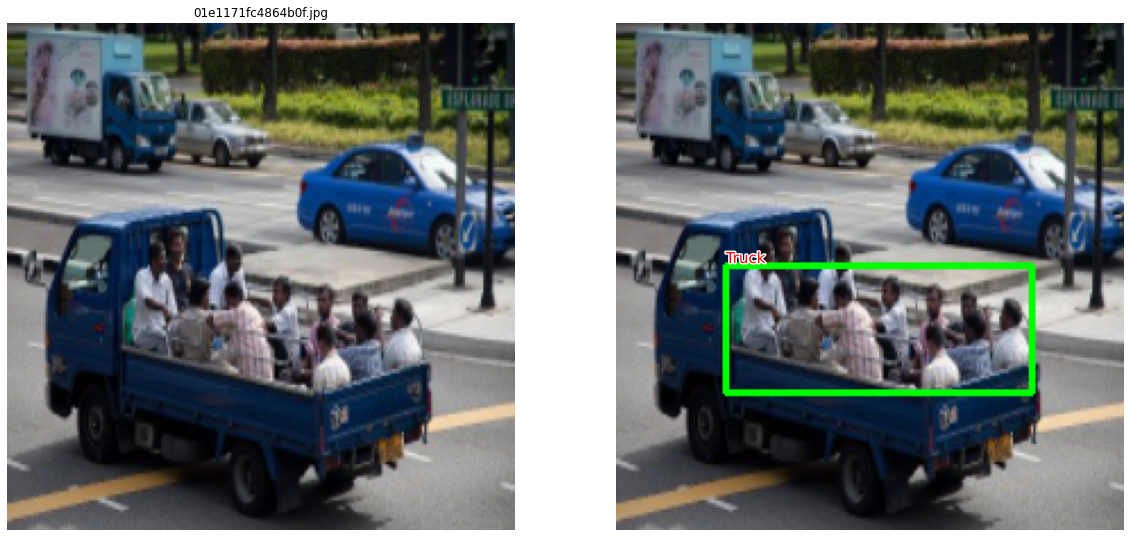

In [ ]:
test_predictions(test_ds[29][-1])

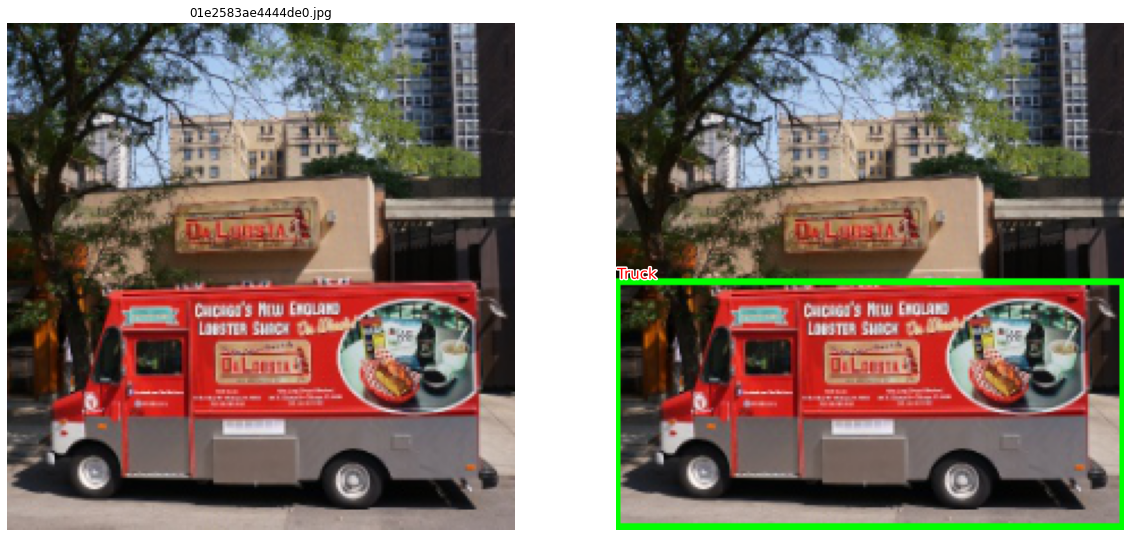

In [ ]:
test_predictions(test_ds[30][-1])

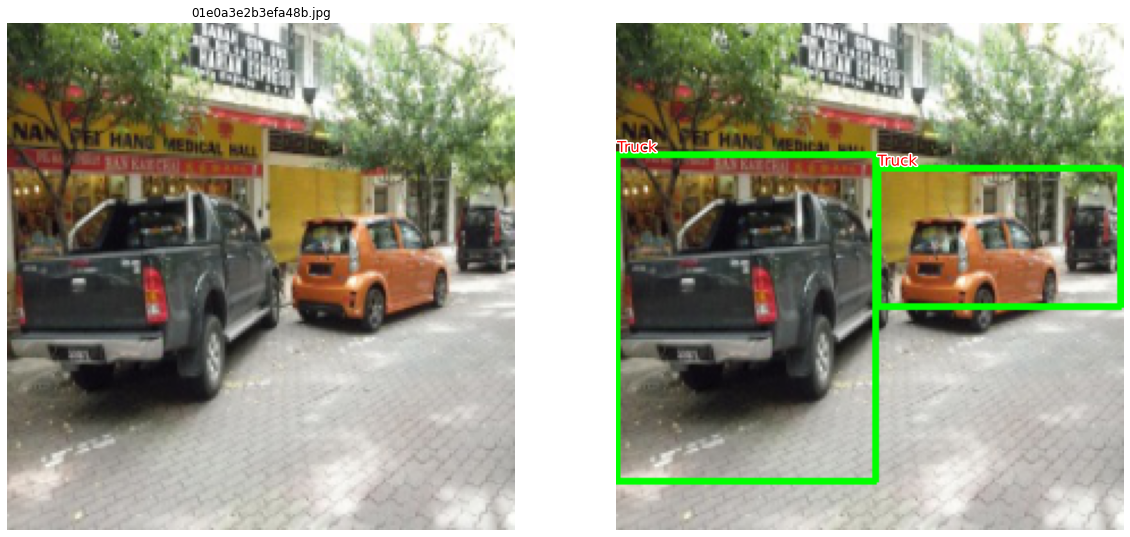

In [ ]:
test_predictions(test_ds[28][-1])

The preceding code executes in 0.5 seconds, which is significantly better than that of R-CNN. However, it is still very slow to be used in real time. This is primarily because we are still using two different models, one to generate region proposals and another to make predictions of class and corrections.

So we need a single model to make predictions, so that inference is quick in a realtime scenario.